# LMC

In [1]:
# imports
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import pandas

from astropy.coordinates import SkyCoord
from astropy import units

from scipy import interpolate
from scipy.stats import pearsonr, ks_2samp

from frb.halos import models

# Init

In [2]:
rstate = np.random.RandomState()

In [3]:
Nrandom=20000
zmax=1.
N_rvir=1.

In [4]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('talk')

## DM$_{\rm cosmic}$ grid

In [5]:
grid_file = '/home/xavier/papers/FRB/Proposals/DM_CDF_grid.npz'

In [6]:
nsz = np.load(grid_file)
DM_grid = nsz['DM_grid']
zvals = nsz['zvals']
CDF_val = nsz['CDF_val']
f2D_cosmic = interpolate.RectBivariateSpline(CDF_val, zvals, DM_grid)

## Pandas

In [7]:
df = pandas.DataFrame()

# FRB redshift

In [8]:
zFRB = rstate.uniform(0., zmax, Nrandom)

In [9]:
df['zFRB'] = zFRB

# Random DM$_{\rm cosmic}$

In [10]:
randnum = rstate.rand(Nrandom)
DM_cosmic = f2D_cosmic.ev(randnum, zFRB)

In [11]:
df['DM_cosmic'] = DM_cosmic

## Plot

<AxesSubplot:xlabel='zFRB', ylabel='DM_cosmic'>

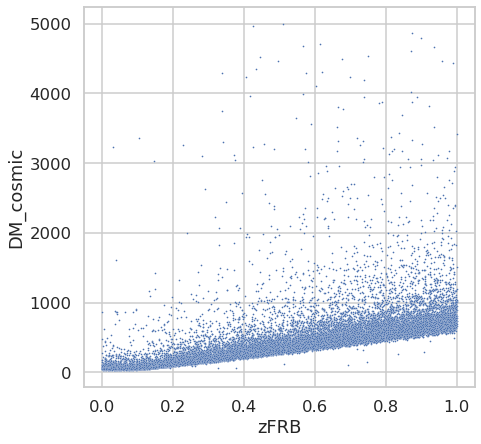

In [12]:
fig = plt.figure(figsize=(7,7))
sns.scatterplot(data=df, x='zFRB', y='DM_cosmic', s=3)

# Milky Way ISM/Halo scatter

In [13]:
# ISM+halo -- Assume +/- 15 pc cm^-3 uncertainty in NE2001 model
sig_ISM = rstate.uniform(-15., 15., Nrandom)

In [14]:
# Galaxy
DM_MW_halo = 50. # pc/cm^3

In [15]:
df['DM_MW_halo'] = DM_MW_halo
df['DM_ISM'] = sig_ISM

# DM$_{\rm host}$

## Should probably use the log-normal PDF eventually

In [16]:
# Host halo
DM_halo = np.maximum(rstate.normal(40., 20., Nrandom), 0.)  # pc/cm^3

In [17]:
df['DM_halo'] = DM_halo

# Random direction on the sky

In [18]:
# Random direction
ranl = rstate.uniform(0,360., Nrandom)  # deg
costheta = rstate.uniform(-1, 1, Nrandom)
ranb = np.arccos(costheta)*180./np.pi - 90. # deg
ran_coord = SkyCoord(b=ranb, l=ranl, frame='galactic', unit='deg')

In [19]:
np.min(ranb)

-89.41580512738842

# LMC

## Instantiate

In [20]:
# M31
LMC = models.LMC(log_Mhalo=11.)
LMC

<LMC: 05:23:34.6 -69:45:22, logM=11.000000, r200=122.399 kpc>

## Interpolate DMs

In [23]:
Rmin = 3. # kpc -- Take a constant value within this impact parameter
Rvals = np.linspace(Rmin, N_rvir*LMC.r200.value, 200) # For splining
DMvals = np.zeros_like(Rvals)
for kk, iRperp in enumerate(Rvals):
    DMvals[kk] = LMC.Ne_Rperp(iRperp * units.kpc, rmax=N_rvir).to('pc/cm**3').value
fDM = interpolate.interp1d(Rvals, DMvals, kind='cubic')

## Project

In [24]:
a=1
c=0
x0, y0 = LMC.distance.to('kpc').value, 0. # kpc (Riess, A.G., Fliri, J., & Valls - Gabaud, D. 2012, ApJ, 745, 156)

sep = LMC.coord.separation(ran_coord)

atan = np.arctan(sep.radian)
b = -1 * a / atan
Rperp = np.ones(Nrandom)*9e9 # kpc
ok = sep < 90.*units.deg
Rperp[ok] = np.abs(a * x0 + b[ok] * y0 + c) / np.sqrt(a ** 2 + b[ok] ** 2)  # kpc

## DMs

In [25]:
DM_LMC = np.zeros(Nrandom)
in_ism = Rperp <= Rmin
in_halo = (Rperp < N_rvir*LMC.r200.value) & (Rperp > Rmin)
out_halo = (Rperp > N_rvir*LMC.r200.value)
DM_LMC[in_ism] = np.max(DMvals)
DM_LMC[in_halo] = fDM(Rperp[in_halo])

In [26]:
df['DM_LMC'] = DM_LMC
# Labels
lbls = np.array(['out']*Nrandom)
lbls[~out_halo] = 'in'
df['LMC'] = lbls

In [27]:
# Sum em up
total_DMs = DM_cosmic + DM_halo + DM_LMC + sig_ISM + DM_MW_halo

In [28]:
df['total'] = total_DMs

# Compare

## Histogram

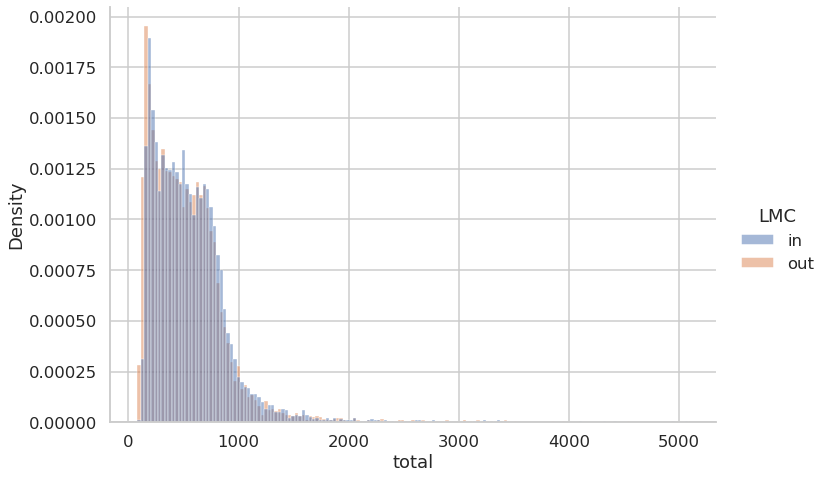

In [30]:
_ = sns.displot(df, x='total', hue='LMC', stat='density', common_norm=False, height=7., aspect=1.5)

## CDF

(0.0, 1000.0)

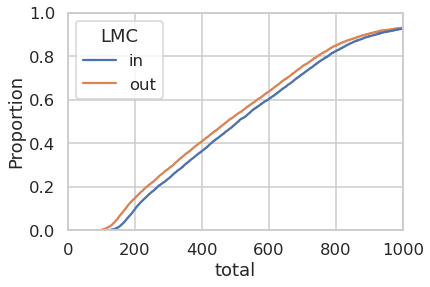

In [31]:
ax = sns.ecdfplot(data=df, x='total', hue='LMC')
ax.set_xlim(0., 1000.)

### KS

In [32]:
D_stat, P_KS = ks_2samp(total_DMs[out_halo], total_DMs[~out_halo])
P_KS

1.131641963715065e-14

In [34]:
np.mean(DM_LMC[~out_halo])

28.386013810353997